# Daily Expenses Simulation – Transaction Size & Simulation Model (Compound Poisson)

In [11]:

# 1. Setup and imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gamma, lognorm
import seaborn as sns
import json

%matplotlib inline
sns.set(style='whitegrid')
np.random.seed(42)  # For reproducibility


## 2. Load & Clean the Data

In [12]:

# Load Excel
df = pd.read_excel("data/data_assignment.xlsx", sheet_name=0, parse_dates=['Date'])
df['Income/Expense'] = df['Income/Expense'].str.strip().str.lower()

# Identify income/expense entries
df['is_income'] = df['Income/Expense'].isin(['income', 'in', 'credit', '+'])
df['is_expense'] = df['Income/Expense'].isin(['expense', 'out', 'debit', '-'])

# Use sign as fallback if labels are missing
if not (df['is_income'].any() or df['is_expense'].any()):
    df['is_income'] = df['Amount'] > 0
    df['is_expense'] = df['Amount'] < 0

# Create magnitude columns
df['income_mag'] = np.where(df['is_income'], df['Amount'], np.nan)
df['expense_mag'] = np.where(df['is_expense'], np.abs(df['Amount']), np.nan)

df = df.sort_values('Date').reset_index(drop=True)
df.head()


,Date,Category,Income/Expense,Amount,is_income,is_expense,income_mag,expense_mag
0,2025-03-01 13:30:00,Other,income,80.0,True,False,80.0,NaN
1,2025-03-01 15:50:00,Food,expense,35.0,False,True,NaN,35.0
2,2025-03-01 17:07:00,Transportation,expense,5.2,False,True,NaN,5.2
3,2025-03-02 14:16:00,Food,expense,3.9,False,True,NaN,3.9
4,2025-03-02 14:16:00,Food,expense,3.6,False,True,NaN,3.6


## 3. ECDF and Distribution Fitting (Gamma, Lognormal, Log-logistic)

In [13]:

def ecdf(x):
    x = np.sort(x)
    y = np.arange(1, len(x)+1) / len(x)
    return x, y

def gamma_mom(x):
    mean = np.mean(x)
    var = np.var(x, ddof=1)
    k = mean ** 2 / var
    theta = var / mean
    return k, theta

def lognormal_mom(x):
    mean = np.mean(x)
    var = np.var(x, ddof=1)
    sigma2 = np.log(1 + var / mean**2)
    mu = np.log(mean) - 0.5 * sigma2
    return mu, np.sqrt(sigma2)

def loglogistic_quantile(x):
    med = np.percentile(x, 50)
    q75 = np.percentile(x, 75)
    r = q75 / med
    beta = np.log(3) / np.log(r)
    alpha = med
    return alpha, beta


In [14]:

income_x = df['income_mag'].dropna()
expense_x = df['expense_mag'].dropna()

# Income fits
gk_I, gtheta_I = gamma_mom(income_x)
lmu_I, lsig_I = lognormal_mom(income_x)
lla_I, llb_I = loglogistic_quantile(income_x)

# Expense fits
gk_E, gtheta_E = gamma_mom(expense_x)
lmu_E, lsig_E = lognormal_mom(expense_x)
lla_E, llb_E = loglogistic_quantile(expense_x)


## 4. Plot ECDFs with Fitted CDFs

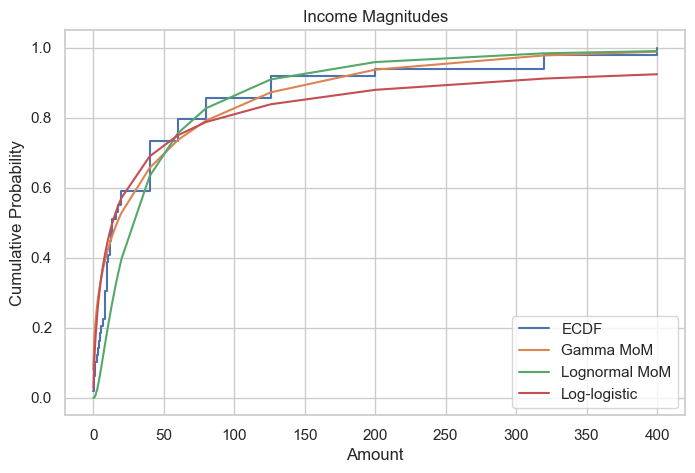

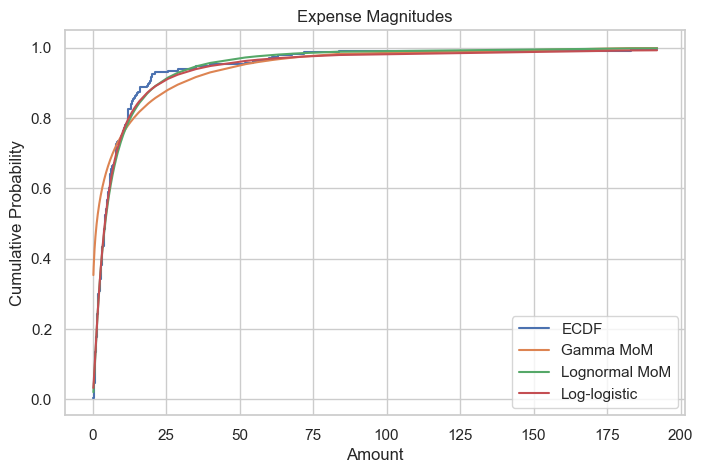

In [15]:

# Plot ECDFs
def plot_ecdf_with_fits(x, title, g_params, l_params, ll_params):
    x_sorted, y = ecdf(x)
    plt.figure(figsize=(8, 5))
    plt.step(x_sorted, y, where='post', label='ECDF')

    if g_params:
        plt.plot(x_sorted, gamma.cdf(x_sorted, a=g_params[0], scale=g_params[1]), label='Gamma MoM')
    if l_params:
        plt.plot(x_sorted, lognorm.cdf(x_sorted, s=l_params[1], scale=np.exp(l_params[0])), label='Lognormal MoM')
    if ll_params:
        alpha, beta = ll_params
        F = 1 / (1 + (alpha / x_sorted)**beta)
        plt.plot(x_sorted, F, label='Log-logistic')

    plt.title(title)
    plt.xlabel("Amount")
    plt.ylabel("Cumulative Probability")
    plt.legend()
    plt.show()

plot_ecdf_with_fits(income_x, "Income Magnitudes", (gk_I, gtheta_I), (lmu_I, lsig_I), (lla_I, llb_I))
plot_ecdf_with_fits(expense_x, "Expense Magnitudes", (gk_E, gtheta_E), (lmu_E, lsig_E), (lla_E, llb_E))


## 5. Store Parameters for Simulation

In [17]:

params = {
    'income': {
        'gamma': {'k': gk_I, 'theta': gtheta_I},
        'lognormal': {'mu': lmu_I, 'sigma': lsig_I},
        'loglogistic': {'alpha': lla_I, 'beta': llb_I}
    },
    'expense': {
        'gamma': {'k': gk_E, 'theta': gtheta_E},
        'lognormal': {'mu': lmu_E, 'sigma': lsig_E},
        'loglogistic': {'alpha': lla_E, 'beta': llb_E}
    }
}
with open("fitted_params.json", "w") as f:
    json.dump(params, f, indent=2)
print("Saved to fitted_params.json")


Saved to fitted_params.json


## 6. Size Sampler Functions

In [18]:

def sample_size(dist_name, params):
    u = np.random.uniform()
    if dist_name == 'gamma':
        return np.random.gamma(params['k'], params['theta'])
    elif dist_name == 'lognormal':
        return np.random.lognormal(params['mu'], params['sigma'])
    elif dist_name == 'loglogistic':
        alpha = params['alpha']
        beta = params['beta']
        return alpha * (u / (1 - u))**(1 / beta)
    else:
        raise ValueError("Unsupported distribution")


## 7. Combined Compound Poisson Process Simulation

In [19]:

def simulate_balance(H_days, R, lambda_total, p_income, dist_choice, scenario=None):
    income_params = params['income'][dist_choice]
    expense_params = params['expense'][dist_choice]

    B_end = []
    P_neg = []
    T_neg = []

    for _ in range(R):
        t = 0
        B = 0
        time_neg = 0
        prev_t = 0

        while t < H_days:
            delta = np.random.exponential(1 / lambda_total)
            t += delta
            if t > H_days:
                break

            if B < 0:
                time_neg += (t - prev_t)
            prev_t = t

            if np.random.rand() < p_income:
                B += sample_size(dist_choice, income_params)
            else:
                x = sample_size(dist_choice, expense_params)
                if scenario == "transport_10pct":
                    x *= 1.10
                B -= x

        if B < 0:
            time_neg += (H_days - prev_t)

        B_end.append(B)
        P_neg.append(int(B < 0))
        T_neg.append(time_neg)

    return {
        'mean_end_balance': np.mean(B_end),
        'ci_end_balance': 1.96 * np.std(B_end) / np.sqrt(R),
        'prob_negative': np.mean(P_neg),
        'ci_prob_negative': 1.96 * np.sqrt(np.mean(P_neg)*(1-np.mean(P_neg))/R),
        'mean_days_negative': np.mean(T_neg),
        'ci_days_negative': 1.96 * np.std(T_neg) / np.sqrt(R)
    }


## 8. Run Baseline Simulation

In [20]:

# Replace with your actual lambda and p values from partner
lambda_total = 1.2  # e.g., 1.2 events/day
p_income = 0.4      # 40% of arrivals are income

baseline = simulate_balance(H_days=90, R=10000, lambda_total=lambda_total, p_income=p_income, dist_choice='gamma')
baseline


{'mean_end_balance': np.float64(1623.27409424414),
 'ci_end_balance': np.float64(13.61158934638323),
 'prob_negative': np.float64(0.0025),
 'ci_prob_negative': np.float64(0.0009787742334164708),
 'mean_days_negative': np.float64(6.573807366181169),
 'ci_days_negative': np.float64(0.20232145404844648)}